In [109]:
# Author: Jiatong Yang
# Last modified: 04/09/2025

import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

from cycler import cycler
from qutip import (
    Qobj, basis, coherent, create, destroy, expect,
    fock, fock_dm, mesolve, qeye, sigmax, sigmay,
    sigmaz, thermal_dm, tensor, ket2dm, solver, sesolve
    )


In [2]:
def solve_eigen_states(hamiltonian, N, eigenstates=False):
    """
    Solves the eigenvalue problem for the Hamiltonian matrix with scipy.linalg.
    Returns the first N eigenvalues and eigenvectors.
    """

    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian)

    # Sort the eigenvalues and eigenvectors
    indices = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:, indices]

    # Return the first N eigenvalues and eigenstates if requested
    if eigenstates:
        return eigenvalues[:N], eigenvectors[:, :N]
    else:
        return eigenvalues[:N]

## 2(a) Landau-Zener transitions in a driven two-level system: Hamiltonian and energy levels

Minimum separation between ground and excited states: 102.02 MHz


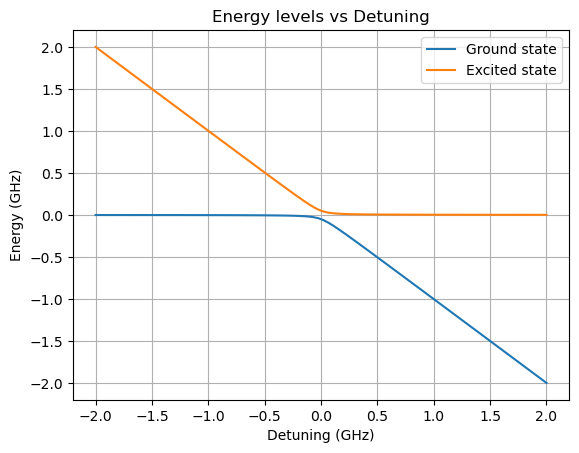

In [134]:
psi_gnd = basis(2, 0)
psi_exc = basis(2, 1)

delta = 2*np.pi*np.linspace(-2, 2, 100)*1e9 # detuning
Omega = 2*np.pi*0.1e9 # Rabi frequency
energy = np.zeros((len(delta), 2))

for i, delta_crt in enumerate(delta):
    H = - delta_crt * psi_exc * psi_exc.dag() + Omega/2 * sigmax()
    H = H.full()
    energy[i,:] = solve_eigen_states(H, 2, eigenstates=False)

min_sep = min(np.abs(energy[:,0]-energy[:,1]))/2/np.pi/1e6 # MHz
print(f"Minimum separation between ground and excited states: {min_sep:.2f} MHz")

plt.plot(delta/1e9/2/np.pi, energy[:, 0]/1e9/2/np.pi, label='Ground state')
plt.plot(delta/1e9/2/np.pi, energy[:, 1]/1e9/2/np.pi, label='Excited state')
plt.xlabel('Detuning (GHz)')
plt.ylabel('Energy (GHz)')
plt.title('Energy levels vs Detuning')
plt.legend()
plt.grid()

## 2(b) Drive with a linearly time-dependent detuning

In [125]:
Omega = 2*np.pi*0.01e9 # Rabi frequency
d_0 = 2*np.pi*0.2e9 # detuning
psi_gnd = basis(2, 0)
psi_exc = basis(2, 1)

a_start = d_0*5e5
a_end = d_0*1e10

alist = np.logspace(np.log(a_start), np.log(a_end), 1000, base=np.exp(1)) # drive amplitude
end_exc_prob = np.zeros(len(alist))


for i, a in tqdm(enumerate(alist), total=len(alist)):
    H_0 = Omega/2 * sigmax()  # Bare Hamiltonian
    H_d = - psi_exc * psi_exc.dag()  # Drive Hamiltonian
    H_tot = [H_0, [H_d, "-d + a*t"]] # Total Hamiltonian
    args = {"d": d_0, "a": a} 

    tlist = np.linspace(0, 2*d_0/a, 200)  # time list
    result = mesolve(H_tot, psi_gnd, tlist, [], [psi_exc*psi_exc.dag()], args=args)
    end_exc_prob[i] = result.expect[0][-1]




  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jiatongyang/opt/anaconda3/envs/qutip-env/lib/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
100%|██████████| 1000/1000 [00:40<00:00, 24.65it/s]


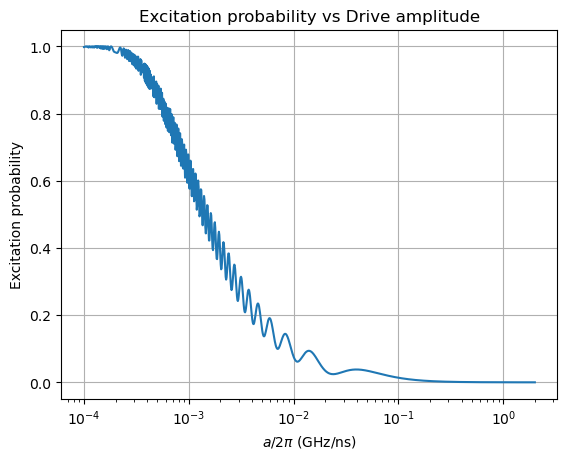

In [126]:
plt.figure()
#plt.plot(alist/d_0/2/1e6, end_exc_prob)
plt.plot(alist/2/np.pi/1e9/1e9, end_exc_prob)
plt.xscale('log')
#plt.xlabel(r'$a/(2\delta_0) = 1/t_{end}$ (MHz)')
plt.xlabel(r'$a/2\pi$ (GHz/ns)')
plt.ylabel('Excitation probability')
plt.title('Excitation probability vs Drive amplitude')
plt.grid()

## 2(c) Drive with a sinusoidal time-dependent detuning

In [129]:
Omega = 2*np.pi*0.01e9 # Rabi frequency
d_0_list = 2*np.pi*np.linspace(-0.02, 0.02, 49)*1e9 # detuning

t_end_list = np.linspace(1e-9, 200e-9, 50) # time for one Rabi oscillation

end_exc_prob = np.zeros((len(d_0_list), len(t_end_list)))

psi_gnd = basis(2, 0)
psi_exc = basis(2, 1)

for i, d_0 in tqdm(enumerate(d_0_list), total=len(d_0_list)):
    for j, t_end in enumerate(t_end_list):

        a = 2*np.pi/t_end
        H_0 = Omega/2 * sigmax()  # Bare Hamiltonian
        H_d = - psi_exc * psi_exc.dag()  # Drive Hamiltonian
        H_tot = [H_0, [H_d, "d*sin(a*t)"]] # Total Hamiltonian
        args = {"d": d_0, "a": a} 

        tlist = np.linspace(0, t_end, 100)  # time list
        result = mesolve(H_tot, psi_gnd, tlist, [], [psi_exc*psi_exc.dag()], args=args, options=options)
        end_exc_prob[i,j] = result.expect[0][-1]


  0%|          | 0/49 [00:00<?, ?it/s]/Users/jiatongyang/opt/anaconda3/envs/qutip-env/lib/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
100%|██████████| 49/49 [00:35<00:00,  1.39it/s]


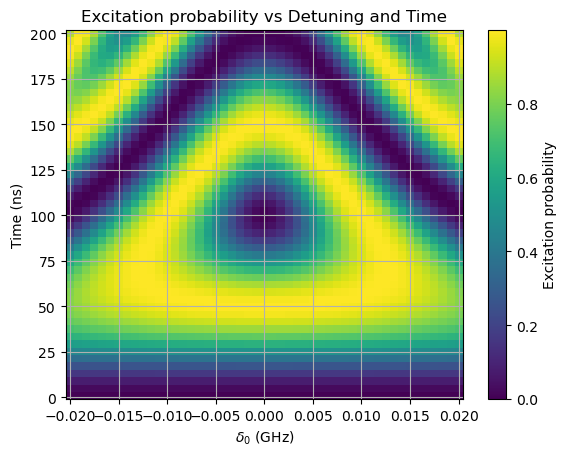

In [130]:

# 2D heatmap of the end excitation probability vs detuning and time
# Use pcolormesh instead of imshow to fix the axis better

plt.figure()
plt.pcolormesh(d_0_list/1e9/2/np.pi, t_end_list*1e9, end_exc_prob.T, shading='auto')
plt.colorbar(label='Excitation probability')
plt.xlabel(r'$\delta_0$ (GHz)')
plt.ylabel('Time (ns)')
plt.title('Excitation probability vs Detuning and Time')
plt.grid()  


## 5(a) Cross-resonance Hamiltonian

In [136]:
w1 = 4.9e9
w2 = 5.1e9
a1 = -0.66e9
a2 = -0.66e9
J = 0.005e9

H1 = tensor(w1*create(3)*destroy(3)+a1/2*create(3)*create(3)*destroy(3)*destroy(3), qeye(3))
H2 = tensor(qeye(3), w2*create(3)*destroy(3)+a2/2*create(3)*create(3)*destroy(3)*destroy(3))
H_int = J*tensor(create(3)+destroy(3), create(3)+destroy(3))
H = H1 + H2 + H_int

energies, estates = H.eigenstates()
print((energies-energies[0])/1e9)
print('The 6th one is the |11> state energy (10=4.9+5.1)')
#print(estates)

[ 0.          4.89987222  5.10012207  9.13994436  9.53989386 10.00016027
 14.2395091  14.44050661 18.68001402]
The 6th one is the |11> state energy (10=4.9+5.1)


## 5(b) Driving with a cosine pulse

In [ ]:
def cos_pulse(t, args):
    "Create a pulse of sine waves with angular frequency w_sin that has a cosine envelop"

    return np.sin(args['w_sin']*t)*(np.cos(args['w_cos']*t+np.pi/2))**2

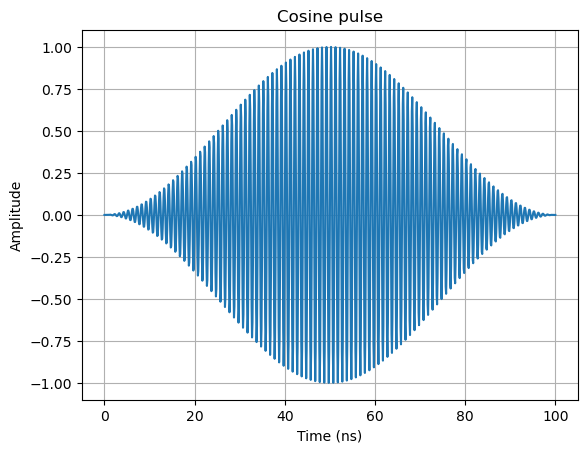

In [151]:
# Plot the pulse

tlist = np.linspace(0, 100, 1000)*1e-9
w_sin = 2*np.pi*1e9
pulse = cos_pulse(tlist, {"w_sin": w_sin, 'w_cos': np.pi/tlist[-1]})

plt.figure()
plt.plot(tlist*1e9, pulse)
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.title('Cosine pulse')
plt.grid()

## 5(c) Driving the qubits

In [189]:
Omega = 0.4e9*2*np.pi
w1 = 4.9e9*2*np.pi
w2 = 5.1e9*2*np.pi
a1 = -0.66e9*2*np.pi
a2 = -0.66e9*2*np.pi
J = 0.005e9*2*np.pi
wd = (energies[2]-energies[0])*2*np.pi
pulse_width = np.linspace(1, 1000, 100)*1e-9
end_popul = np.zeros((4, len(pulse_width)))


psi_00 = tensor(basis(3, 0), basis(3, 0))
psi_11 = tensor(basis(3, 1), basis(3, 1))
psi_01 = tensor(basis(3, 0), basis(3, 1))
psi_10 = tensor(basis(3, 1), basis(3, 0))

H1 = tensor(w1*create(3)*destroy(3)+a1/2*create(3)*create(3)*destroy(3)*destroy(3), qeye(3))
H2 = tensor(qeye(3), w2*create(3)*destroy(3)+a2/2*create(3)*create(3)*destroy(3)*destroy(3))
H_int = J*tensor(create(3)+destroy(3), create(3)+destroy(3))
H_d = Omega * tensor(create(3)+destroy(3), qeye(3))
H = [H1, H2, H_int, [H_d, cos_pulse]]

options={'nsteps': 1e5}

Rabi_10 = np.zeros(len(pulse_width))
Rabi_00 = np.zeros(len(pulse_width))

  0%|          | 0/100 [00:00<?, ?it/s]/Users/jiatongyang/opt/anaconda3/envs/qutip-env/lib/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
100%|██████████| 100/100 [07:26<00:00,  4.46s/it]


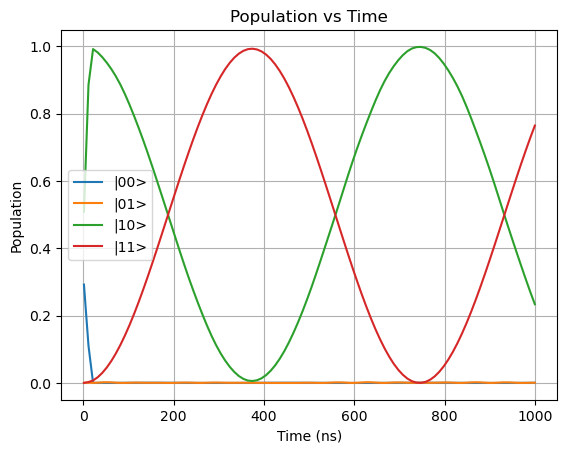

In [190]:

for i, t_end in tqdm(enumerate(pulse_width), total=len(pulse_width)):
    tlist = np.linspace(0, t_end, 100)  # time list
    args = {"w_sin": wd, 'w_cos': np.pi/tlist[-1]}

    result = mesolve(H, psi_10, tlist, [], [psi_00*psi_00.dag(), psi_01*psi_01.dag(),
                                            psi_10*psi_10.dag(), psi_11*psi_11.dag()], args=args, options=options)
    
    end_popul[:,i] = np.array([result.expect[0][-1], result.expect[1][-1], result.expect[2][-1], result.expect[3][-1]])
    Rabi_10[i] = result.expect[3][-1]

plt.figure()
plt.plot(pulse_width*1e9, end_popul[0,:], label='|00>')
plt.plot(pulse_width*1e9, end_popul[1,:], label='|01>')
plt.plot(pulse_width*1e9, end_popul[2,:], label='|10>')
plt.plot(pulse_width*1e9, end_popul[3,:], label='|11>')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title('Population vs Time')
plt.legend()
plt.grid()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/jiatongyang/opt/anaconda3/envs/qutip-env/lib/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
100%|██████████| 100/100 [06:25<00:00,  3.85s/it]


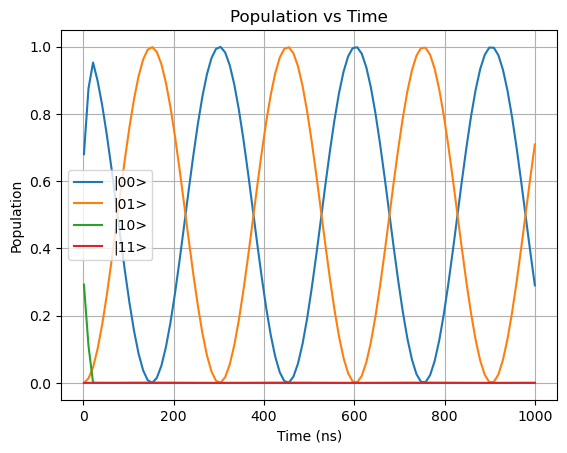

In [191]:
for i, t_end in tqdm(enumerate(pulse_width), total=len(pulse_width)):
    tlist = np.linspace(0, t_end, 100)  # time list
    args = {"w_sin": wd, 'w_cos': np.pi/tlist[-1]}

    result = mesolve(H, psi_00, tlist, [], [psi_00*psi_00.dag(), psi_01*psi_01.dag(),
                                            psi_10*psi_10.dag(), psi_11*psi_11.dag()], args=args, options=options)
    
    end_popul[:,i] = np.array([result.expect[0][-1], result.expect[1][-1], result.expect[2][-1], result.expect[3][-1]])
    Rabi_00[i] = result.expect[1][-1]

plt.figure()
plt.plot(pulse_width*1e9, end_popul[0,:], label='|00>')
plt.plot(pulse_width*1e9, end_popul[1,:], label='|01>')
plt.plot(pulse_width*1e9, end_popul[2,:], label='|10>')
plt.plot(pulse_width*1e9, end_popul[3,:], label='|11>')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title('Population vs Time')
plt.legend()
plt.grid()


## 5(d) $\pi$ pulse

Rabi frequency for |00>: 3.319256295883062 MHz
Rabi frequency for |10>: 1.3420781029434847 MHz
Pulse width for pi phase difference: 253.3 ns


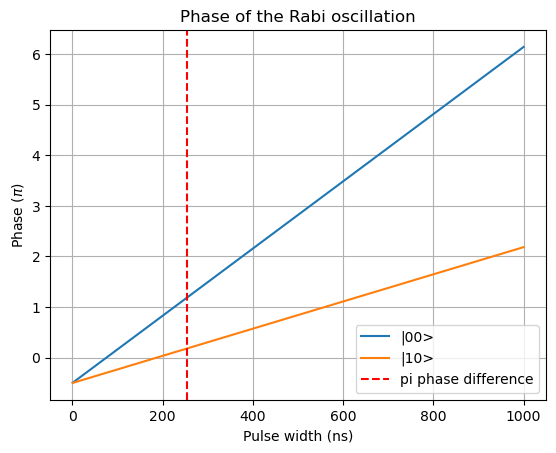

In [211]:
# Fit sine function to the Rabi_00 and Rabi_10 data to extract the Rabi frequency

from scipy.optimize import curve_fit

def sine_func(x, A, omega, phi, offset):

    return A * np.sin(omega * x + phi) + offset

# Fit the data
popt_00, _ = curve_fit(sine_func, pulse_width, Rabi_00, p0=[0.5, 2*np.pi*3*1e6, -np.pi/2, 0.5])
popt_10, _ = curve_fit(sine_func, pulse_width, Rabi_10, p0=[0.5, 2*np.pi*1e6, -np.pi/2, 0.5])

# Extract the Rabi frequency
Rabi_freq_00 = popt_00[1]
Rabi_freq_10 = popt_10[1]

# Calculate the phase of the Rabi oscillation at different pulse_width
phase_00 = Rabi_freq_00 * pulse_width + popt_00[2]
phase_10 = Rabi_freq_10 * pulse_width + popt_10[2]

print(f"Rabi frequency for |00>: {Rabi_freq_00/2/np.pi/1e6} MHz")
print(f"Rabi frequency for |10>: {Rabi_freq_10/2/np.pi/1e6} MHz")

# Find the pulse width that gives pi phase difference between 00 and 10 Rabi oscillations

pi_idx = np.argmin(np.abs((np.abs(phase_00 - phase_10) - np.pi)))
pi_width = pulse_width[pi_idx]

print(f"Pulse width for pi phase difference: {pi_width*1e9:.1f} ns")

# Plot the phase of the Rabi oscillation
plt.figure()
plt.plot(pulse_width*1e9, phase_00/np.pi, label='|00>')
plt.plot(pulse_width*1e9, phase_10/np.pi, label='|10>')
plt.axvline(pi_width*1e9, color='r', linestyle='--', label='pi phase difference')
plt.xlabel('Pulse width (ns)')
plt.ylabel(r'Phase ($\pi$)')
plt.title('Phase of the Rabi oscillation')
plt.legend()
plt.grid()

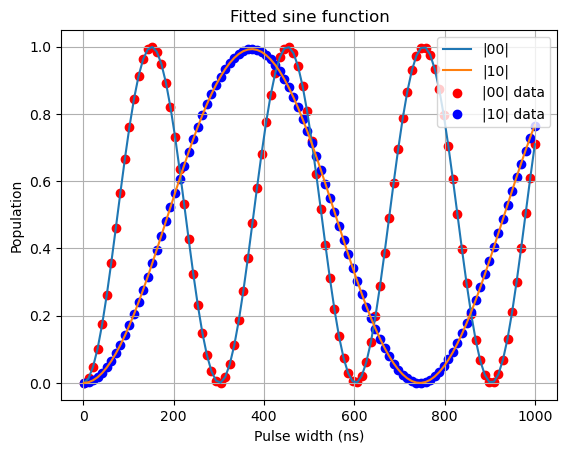

In [207]:
# plot fitted sine function
plt.figure()
plt.plot(pulse_width*1e9, sine_func(pulse_width, *popt_00), label='|00|')
plt.plot(pulse_width*1e9, sine_func(pulse_width, *popt_10), label='|10|')
plt.scatter(pulse_width*1e9, Rabi_00, label='|00| data', color='red')
plt.scatter(pulse_width*1e9, Rabi_10, label='|10| data', color='blue')
plt.xlabel('Pulse width (ns)')
plt.ylabel('Population')
plt.title('Fitted sine function')
plt.legend()
plt.grid()